#### 1. This section is about empirical Hamiltonian error vs. real integration time by integrator

In [ ]:
from functools import partial

import pandas as pd
import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

from special_unitary import (
    fast_expi_su3,
    special_unitary_grad,
    unitary_violation,
    proj_SU3
)

from integrators import int_2LF, int_2MN, int_4MN4FP, int_4MN5FV
from gauge_field_utils import (
    luscher_weisz_action,
    luscher_weisz_gauge_error,
)

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def HMC(action_fn, error_fn, integrator, tau_md=1.0, steps_md=10, unitary_violation_tol=5e-6):

    action_grad = special_unitary_grad(action_fn)
    
    def step_fn(links, random_key, skip_metropolis=False):
        key1, key2 = jax.random.split(random_key, 2)
        Nc = links.shape[-1]

        p0 = jax.random.normal(key1, shape=(*links.shape[:-2], Nc*Nc-1))

        links_next, p_final = integrator(links, p0, action_grad, tau_md, steps_md)
        links_next = jax.lax.cond(
            unitary_violation_tol is not None,
            lambda: jax.lax.cond(
                unitary_violation(links_next, "mean") > unitary_violation_tol,
                proj_SU3,
                lambda x: x,
                links_next
            ),
            lambda: links_next
        )

        delta_hamiltonian = error_fn(links, p0, links_next, p_final)
        p_acc = jnp.minimum(1, jnp.exp(-delta_hamiltonian))
        
        return jax.lax.cond(
            skip_metropolis,
            lambda: links_next,
            lambda: jax.lax.cond(
                jax.random.uniform(key2) < p_acc,
                lambda: links_next,
                lambda: links
            )
        ), (delta_hamiltonian, p_acc)
    
    return jax.jit(step_fn)

In [3]:
make_stepper_fn = partial(
    HMC,
    action_fn=partial(luscher_weisz_action, beta=8.00, u0=0.8876875888655319),
    error_fn=partial(luscher_weisz_gauge_error, beta=8.00, u0=0.8876875888655319),
    # integrator=int_4MN4FP,
    tau_md=1.0,
    # steps_md=25,
    unitary_violation_tol=5e-6
)

In [4]:
import time

def test_stepper(stepper, initial_links, random_key, n_trajectories=30):
    # warmup
    stepper(initial_links, random_key)

    times = []
    errors = []

    next_links = initial_links
    for i in tqdm(range(n_trajectories)):
        random_key, _k = jax.random.split(random_key)

        start_time = time.time()
        next_links, (err, _) = stepper(next_links, _k)
        end_time = time.time()
        
        times.append(end_time - start_time)
        errors.append(err.item())
    
    return times, errors

In [5]:
random_key, _k = jax.random.split(jax.random.key(0), num=2)

# L = (8, 8, 8, 8)
# gauge_links = fast_expi_su3(jax.random.normal(
#     _k,
#     shape=(*L, 4, 8),
#     dtype=jnp.float32
# ))

gauge_links = jnp.load("../results/configs_3-25-25_2/configs_3-25-25_2.npz")["arr_500"]

In [6]:
integrators = {
    "2MN": int_2MN,
    "4MN4FP": int_4MN4FP,
    "4MN5FV": int_4MN5FV
}
step_numbers = [3, 5, 8, 10]

results = dict()
for int_name, integrator in integrators.items():
    results[int_name] = dict()

    for steps_md in step_numbers:
        stepper = make_stepper_fn(integrator=integrator, steps_md=steps_md)

        times, errors = test_stepper(stepper, gauge_links, random_key, n_trajectories=30)

        results[int_name][steps_md] = {
            "times": times,
            "errors": errors
        }

100%|██████████| 30/30 [05:23<00:00, 10.77s/it]


In [7]:
results_df = pd.concat([
    pd.concat([pd.DataFrame.from_dict(int_step_data),
               pd.DataFrame({"integrator": [int_name]*30, "steps_md": [steps_md]*30})], axis=1)
    for int_name, int_data in results.items() for steps_md, int_step_data in int_data.items()
], axis=0)
results_df["p_acc"] = results_df["errors"].apply(lambda err: 1 if err < 0 else np.exp(-err))
results_df["abs_err"] = results_df["errors"].apply(np.abs)

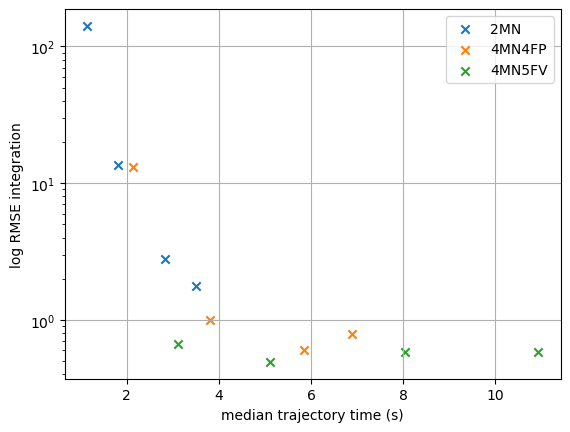

In [ ]:
for int_name, int_data in results_df.groupby(by="integrator"):

    if int_name == "2LF":
        continue

    mean_times = []
    mean_errs = []
    mean_probs = []

    for steps_md, int_step_data in int_data.groupby(by="steps_md"):

        mean_times.append(int_step_data["times"].median())
        mean_errs.append(
            np.sqrt(np.square(int_step_data["errors"]).mean())
        )
        mean_probs.append(int_step_data["p_acc"].mean())
    
    plt.scatter(mean_times, mean_errs, label=int_name, marker="x")

plt.xlabel("median trajectory time (s)")
plt.ylabel("log RMSE integration")
plt.legend()
plt.grid()
plt.gca().set_yscale("log")
plt.show()